<a href="https://colab.research.google.com/github/shryu8902/KAERI_mini_BS/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C_1_Quantile_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 미니석사과정 (03.28) 딥러닝 모델 불확실성 정량화 실습 자료


본 실습 자료에서는 불확실성 정량화를 위한 두가지 방법에 대한 실습을 진행합니다.
1. Pytorch lightning 커스텀 모델 만들기
2. GNLL (Gaussian negative log likelihood) loss 를 활용한 mean, variance estimation. (이하 GNLL 모델)
3. Pinball loss를 활용한 multiple quantile regression. (이하 MQR 모델)
4. Probabilistic forecasting을 위한 Metric


# Pytorch-lightning 모델 기초

실습은 pytorch와 pytorch-lightning 라이브러리를 바탕으로 진행합니다.  
아래의 코드 블록을 실행시키면서 결과를 확인 할 수 있습니다.  
Heteroscedastic aleatoric uncertainty를 갖는 가상의 데이터에 대해 오토인코더 기반의 GNLL 모델과 MQR 모델을 학습시켜 출력값의 확률 분포를 모델링합니다.
두가지 모델은 출력값에서 차이가 발생합니다.  
GNLL 모델은 인공신경망의 출력값으로 평균과 표준편차를 얻고 ($\mu, \sigma$)  
MQR 모델은 median과 타겟 quantile 예측값을 얻습니다. ($[y_{\tau_1},y_{\tau_2},...]$)

먼저 아래의 코드를 통해 필요 라이브러리들을 설치 후 import합니다.

In [1]:
# 기초 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
# pytorch-lightning
!pip install pytorch-lightning
import pytorch_lightning as pl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.9 MB/s eta 0:00:00


## 가상의 데이터셋 생성하기
불확실성 정량화 모델을 테스트하기 위하여 임의의 평균과 분산을 가정하여(Heterocedatic aleatoric uncertainty*) Sine function을 이용한 간단한 가상의 데이터셋을 생성해보도록 하겠습니다.


> Heterocedatic aleatoric uncertainty : 입력에 따라서 분포가 달라지는 경우 (등분산이 아닌 경우)


$y=sin(3x)+\frac{x}{2}+\epsilon$으로 가정하고
관측하는 샘플의 불확실성을 유도하는 노이즈 $\epsilon$이 $x$에 따라 상이한 variance를 갖는 정규분포로 모델링하겠습니다.

In [3]:
x = np.linspace(-2,2,10000)
y_mean = np.sin(3*x)+x/2
y_std = np.abs(y_mean/2)
y_unc = np.random.normal(0,y_std)
y = y_mean + y_unc

다음의 그래프는 true y값과 노이즈가 섞인 sample 데이터를 나타낸 그래프입니다.

Text(0.5, 1.0, 'True y and observed samples')

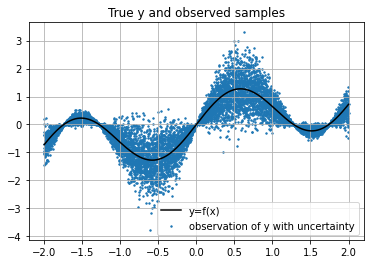

In [4]:
plt.plot(x,y_mean,'-k',label='y=f(x)')
plt.scatter(x,y,s =2, label='observation of y with uncertainty')
plt.legend()
plt.grid()
plt.title('True y and observed samples')

다음 그래프는 $x$에 따른 표준편차 그래프입니다.

Text(0.5, 1.0, 'standard deviation of y according to x')

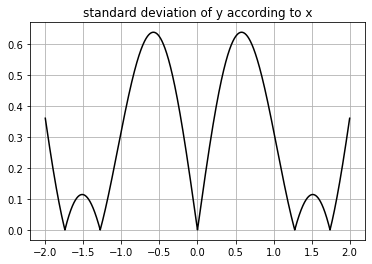

In [5]:
plt.plot(x,y_std,'-k')
plt.grid()
plt.title('standard deviation of y according to x')

## Pytorch-lightning을 활용한 딥러닝 모델 만들기

Pytorch-lightining 라이브러리 (이하 PL)를 활용하여 간단한 신경망 모델을 만들어보도록 하겠습니다.
PL활용시 Keras API와 유사하게 모델 학습 과정을 쉽게 진행할 수 있습니다.

In [6]:
from torch import nn
from torch.nn import functional as F

PL 커스텀 모델은 Trainer를 통해 학습, 테스트, 검증 등을 수행할 수 있습니다.
이를 위해서는 PL 커스텀 모델에서는 다음의 주요 함수들을 정의해야합니다.

필수 요소
-  ```__init__``` : 모델 초기화 및 각종 정보 정의
- ```forward``` : 신경망의 forward path 정의
- ```training_step``` : 신경망 학습 루프 정의 + trainer.fit() 에서 수행되는 내용
- ```configure_optimzier``` : 옵티마이저 셋팅에 대한 내용, e.g., 스케쥴러 사용 등

부가 요소
- ```validation_step``` : 검증 데이터셋에 대한 수행 내용 정의 + trainer.fit() 또는 trainer.validate()
- ```test_step``` : 테스트용 데이터셋에 대한 수행 내용 정의 + trainer.test()에서 수행되는 내용
-```predict_step``` : trainer.predict()에서 수행되는 내용


SimpleMLP라는 이름으로 커스텀 클래스를 생성해보도록하겠습니다. 

본 모델은 2개의 은닉층과 leaky ReLU 활성함수로 구성된 신경망입니다.

In [7]:
class SimpleMLP(pl.LightningModule):
    def __init__(self, input_dim = 100):
        super().__init__()
        self.input_dim = input_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

        self.loss = nn.MSELoss()

    def forward(self, x):
        output = self.model(x)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss(y, output)
        self.log('train_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        return x, output, y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)    
        return optimizer


커스텀 클래스로부터 Trainer를 활용하여 모델 학습을 진행해보도록하겠습니다.
이를 위해서 가상의 학습용 데이터를 구성해보도록합니다.

## 학습 데이터셋 구성

모델 학습이 가능한 형태로 데이터셋을 준비하도록 하겠습니다.

랜덤하게 생성된 10000개의 입/출력 데이터에서 8000, 2000, 2000 개씩 나눠서 

트레이닝, 밸리데이션 셋을 구성하도록 하겠습니다.

In [8]:
X=np.random.uniform(-2,2,10000).reshape((-1,1))
Y_MEAN = np.sin(3*X)+X/2
Y_STD = np.abs(Y_MEAN/2)
Y_UNC = np.random.normal(0,Y_STD)
Y=(Y_MEAN + Y_UNC).reshape((-1,1))

In [10]:
from torch.utils.data import DataLoader, TensorDataset

training_set = TensorDataset(torch.Tensor(X[:6000, ...]), torch.Tensor(Y[:6000, ...]))
validation_set = TensorDataset(torch.Tensor(X[6000:8000, ...]), torch.Tensor(Y[6000:8000, ...]))
test_set = TensorDataset(torch.Tensor(X[8000:, ...]), torch.Tensor(Y[8000:, ...]))

train_loader = DataLoader(training_set, batch_size = 256)
validation_loader = DataLoader(validation_set, batch_size = 256)
test_loader = DataLoader(test_set, batch_size = 256)

## 모델 학습

이제 데이터, 손실함수, 모델이 모두 준비되었으므로, 모델 학습을 시작해보도록 하겠습니다.

In [13]:
from pytorch_lightning.callbacks import EarlyStopping

Model = SimpleMLP(input_dim = 1)

trainer = pl.Trainer(max_epochs = 100)
trainer.fit(Model, train_loader)  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 385   
1 | loss  | MSELoss    | 0     
-------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_step

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


테스트 셋에 대한 모델 예측결과를 살펴보겠습니다.

In [14]:
results = trainer.predict(Model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [15]:
print(type(results))
print('length of results :', len(results))
print('length of [0]-th element in results :', len(results[0]))

<class 'list'>
length of results : 8
length of [0]-th element in results : 3


Predict step에서 입력 x, 이에 대한 모델 출력 output 및 정답 y를 출력하도록 만들었기 때문에 결과는 미니배치 수 만큼의 길이를 갖는 리스트에 각 리스트 안에는 다시 길이가 3인 리스트가 정의되어있습니다.

In [16]:
test_X = np.concatenate([x[0].detach().numpy() for x in results])
test_Y_HAT = np.concatenate([x[1].detach().numpy() for x in results])
test_Y = np.concatenate([x[2].detach().numpy() for x in results])

In [17]:
test_Y.shape

(2000, 1)

이제 예측이 잘되었는지 그래프를 그려보도록하겠습니다.

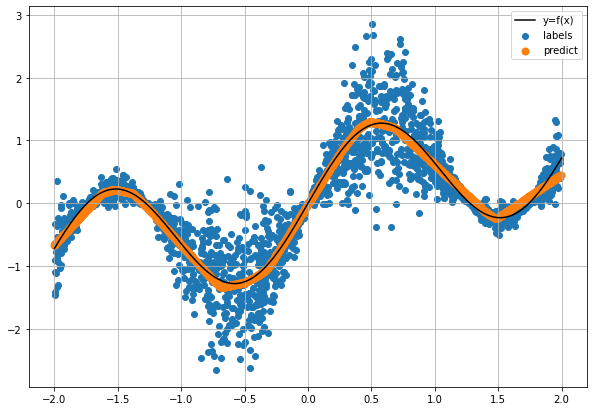

In [18]:
plt.figure(figsize=(10,7))
plt.plot(x,y_mean,'-k',label='y=f(x)')
plt.scatter(test_X,test_Y, linewidth=1, label='labels')
plt.scatter(test_X,test_Y_HAT, linewidth=2, label='predict')

plt.legend()
plt.grid()

# Probabilistic forecasting을 위한 Custom loss

불확실성을 고려하기 위해 이전에 설명드렸던 두가지 Loss (GNLL, MQR)를 구현해보도록 하겠습니다.

pytorch를 기반으로 커스텀 클래스를 생성해보도록 하겠습니다.

In [19]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torchvision import transforms
import pytorch_lightning as pl
import torch.optim as optim


## 1. GNLL loss
일반적인 regression은 mean squared error를 줄이는데, 이루어지며  
이는 Guassian noise distribution에 대한 Maximum likelihood estimation에서  
variance를 상수로 둔 케이스와 같습니다.

따라서 variance를 인공신경망의 출력값으로 함께 고려하는 경우 Guassian negative log likelihood를 loss function으로 활용할 수 있습니다.

Guassina negative loglikelihood의 수식은 다음과 같습니다.

$\frac{1}{2} (\log \sigma^2 +\frac{(y-\mu)^2}{\sigma^2}) + const$

해당 loss를 구현하는데 있어서 일반적으로 상수항은 무시되고 
출력을 통해 예측한 평균과 분산을 가지고 loss가 계산됩니다.

분산을 고려하는 방식은 크게
1. $\sigma$ 혹은 $\sigma^2$ 를 예측하는 방식
2. $\log \sigma^2$를 예측하는 방식

두가지로 구분할 수 있으며,
1번 방식의 경우 학습 안정성과 양수 출력값을 얻기위한 조치들이 필요합니다.

Pytorch에서 GNLL loss function이 구현이 되어있기때문에 이를 활용해보도록하겠습니다.

https://pytorch.org/docs/stable/generated/torch.nn.GaussianNLLLoss.html

구현된 GNLL loss를 보면, MSE에서 input, target을 입력으로 받던것에 더해 var 텀이 추가되어있는 것을 확인할 수 있습니다.

이제 MSE 대신 GNLL loss가 적용된 커스텀 모델을 만들어보겠습니다.
해당 모델의 가장 큰 차이점은 다음과 같습니다.
1. GNLL loss 사용,
2. GNLL loss를 사용하기 위해서 모델이 var 값을 추가적으로 출력


In [20]:
class GNLL_MLP(pl.LightningModule):
    def __init__(self, input_dim = 100):
        super().__init__()
        self.input_dim = input_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
        )
        self.mu_layer = nn.Linear(128,1)
        # var<0 일때 error 가 발생하기 때문에 양수 값으로 출력, ValueError: var has negative entry/entries
        self.var_layer = nn.Sequential(
                            nn.Linear(128,1),
                            nn.Softplus())  
        self.loss = nn.GaussianNLLLoss()

    def forward(self, x):
        latent = self.model(x)
        mu_hat = self.mu_layer(latent) 
        var_hat = self.var_layer(latent)
        return mu_hat, var_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        mu_hat, var_hat  = self(x)
        loss = self.loss(y, mu_hat, var_hat)
        self.log('train_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        mu_hat, var_hat = self(x)
        return x, (mu_hat, var_hat), y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)    
        return optimizer


마찬가지로 Trainer를 통해서 모델을 학습시켜보겠습니다.

In [22]:
Model = GNLL_MLP(input_dim = 1)

trainer = pl.Trainer(max_epochs = 200)
trainer.fit(Model, train_loader)  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params
----------------------------------------------
0 | model     | Sequential      | 256   
1 | mu_layer  | Linear          | 129   
2 | var_layer | Sequential      | 129   
3 | loss      | GaussianNLLLoss | 0     
----------------------------------------------
514       Trainable params
0         Non-trainable params
514       Total params
0.002     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


테스트 셋에 대한 결과를 살펴봅니다.

In [23]:
results = trainer.predict(Model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [24]:
test_X = np.concatenate([x[0].detach().numpy() for x in results])
test_Y_HAT = np.concatenate([x[1][0].detach().numpy() for x in results])
test_Y_VAR = np.concatenate([x[1][1].detach().numpy() for x in results])
test_Y = np.concatenate([x[2].detach().numpy() for x in results])

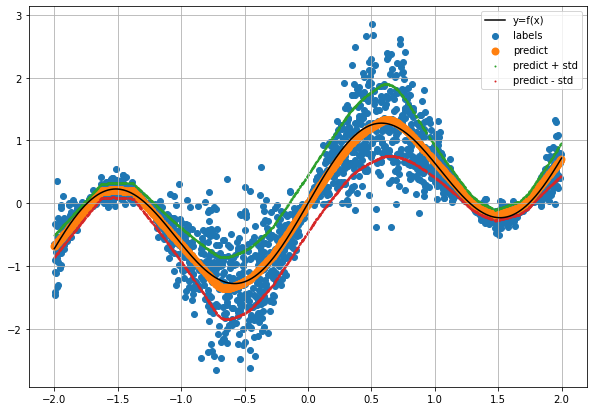

In [25]:
plt.figure(figsize=(10,7))
plt.plot(x,y_mean,'-k',label='y=f(x)')
plt.scatter(test_X,test_Y, linewidth=1, label='labels')
plt.scatter(test_X,test_Y_HAT, linewidth=2, label='predict')
plt.scatter(test_X,test_Y_HAT+np.sqrt(test_Y_VAR), s=1, label='predict + std')
plt.scatter(test_X,test_Y_HAT-np.sqrt(test_Y_VAR), s=1, label='predict - std')
plt.legend()
plt.grid()

저희가 가정했던 standard deviation과 GNLL 트레이닝 결과 얻은 stdard deviation을 비교해보도록하겠습니다.

Text(0.5, 1.0, 'standard deviation of y according to x')

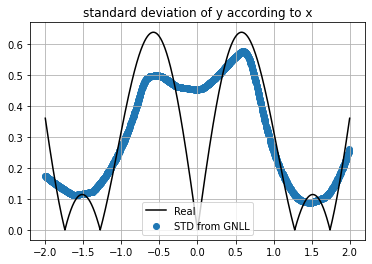

In [26]:
from scipy.stats import norm
plt.plot(x,y_std,'-k',label = 'Real') # 실제 표준편차
plt.scatter(test_X, np.sqrt(test_Y_VAR), label='STD from GNLL')
plt.grid()
plt.legend()
plt.title('standard deviation of y according to x')

## 2. MQR loss
MQR Loss 는 서로다른 target quantile에 대한 pinball loss의 합입니다.
pinball loss의 수식은 다음과 같습니다.

예측하고자 하는 target quantile을 $\tau$, 실제값을 $y$, $\tau$를 예측한 값을 $\hat{y}_\tau$라 하겠습니다.


\begin{equation}
L_\tau(y,\hat{y}_\tau) =
\begin{cases}
  \tau(y-\hat{y}_\tau) & \text{if $y \geq \hat{y}_\tau$} \\
  (1-\tau)(\hat{y}_\tau-y) & \text{if $y < \hat{y}_\tau$}
\end{cases}
\end{equation}

MQR loss 는 $\tau_i \in [\tau_1,...,\tau_N]$에 대해서
$\sum_{\tau_i} L_{\tau_i}(y,\hat{y}_{\tau_i})$ 입니다.

위 내용을 바탕으로 Quantile loss function을 만들어보도록하겠습니다.


MQR loss function은 입력과 출력은 다음과 같이 구성할 수 있습니다.

입력
- 예측 대상 $\tau$들의 리스트
- 대상 $\tau$에 대한 모델의 예측값
- 실제 label y

출력
- 대상 $\tau$에 대한 합산 pinball loss

가정
- 출력은 d차원 변수


In [34]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles = [0.1, 0.5, 0.9], reduction='mean'):
        super().__init__()
        self.quantiles = quantiles
        self.reduction = reduction
        self.qs = torch.Tensor(quantiles)
    
    def forward(self, y_preds, y_true):
        assert y_preds.size()[-1]==len(self.quantiles)

        # y의 사이즈 수정 (N x d -> N x d x q)
        y_trues = y_true.unsqueeze(-1).expand(*(y_true.size()),len(self.quantiles)) 
        # 오차 계산
        # y_preds 는 (N x d x q)의 사이즈를 갖음.
        errors = y_trues - y_preds
        # 오차를 바탕으로 각 q에 대해서 조건문에 맞는 loss를 계산
        losses = torch.max(
            errors*(self.qs.cuda()-1), errors*self.qs.cuda()
        )
        #전체 대상 tau에 대한 summation 수행
        ret = torch.sum(losses,dim=-1)

        if self.reduction != 'none':
            ret = torch.mean(ret) if self.reduction == 'mean' else torch.sum(ret)
        return ret


## 딥러닝 모델 만들기

가상의 데이터셋 생성과 모델 학습을 위한 loss function를 구현하였으므로, 불확실성을 모델링하기 위한 기본적인 딥러닝 모델을 작성하도록 하겠습니다.

Simple MLP 모델을 기반으로
MQR 모델은 다중 퀀타일을 출력하고
loss function은 MQR loss를 사용

In [35]:
class MQR_MLP(pl.LightningModule):
    def __init__(self, target_qs = [0.1,0.3,0.5,0.7,0.9], input_dim = 100):
        super().__init__()
        self.input_dim = input_dim
        self.target_qs = target_qs

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, len(target_qs) )
        )
        self.loss = QuantileLoss(quantiles = target_qs)

    def forward(self, x):
        q_outputs = self.model(x)
        return q_outputs.view([-1, 1, len(self.target_qs)])

    def training_step(self, batch, batch_idx):
        x, y = batch
        q_outputs  = self(x)
        loss = self.loss(y_preds = q_outputs, y_true = y)
        self.log('train_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        q_outputs  = self(x)
        return x, q_outputs, y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)    
        return optimizer


In [36]:
Model = MQR_MLP(input_dim = 1)

trainer = pl.Trainer(max_epochs = 200)
trainer.fit(Model, train_loader)  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | Sequential   | 901   
1 | loss  | QuantileLoss | 0     
---------------------------------------
901       Trainable params
0         Non-trainable params
901       Total params
0.004     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_ev

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


마찬가지로 테스트 데이터에 대한 결과를 정리하고 그래프로 플롯해보겠습니다.

In [37]:
results = trainer.predict(Model, test_loader)
test_X = np.concatenate([x[0].detach().numpy() for x in results])
test_Y_HATS = np.concatenate([x[1].detach().numpy() for x in results])
test_Y = np.concatenate([x[2].detach().numpy() for x in results])

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

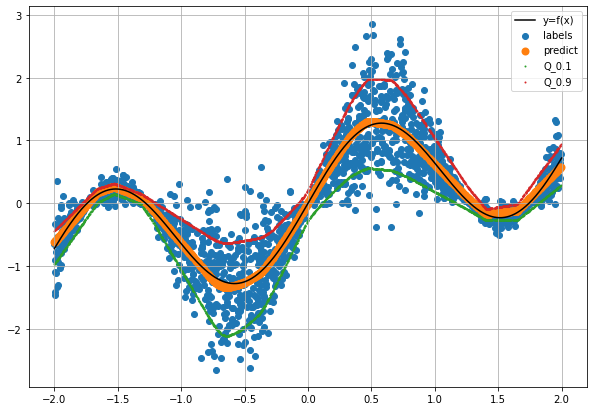

In [42]:
plt.figure(figsize=(10,7))
plt.plot(x,y_mean,'-k',label='y=f(x)')
plt.scatter(test_X,test_Y, linewidth=1, label='labels')
plt.scatter(test_X,test_Y_HATS[...,2], linewidth=2, label='predict')
plt.scatter(test_X,test_Y_HATS[...,0], s=1, label='Q_0.1')
plt.scatter(test_X,test_Y_HATS[...,4], s=1, label='Q_0.9')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'standard deviation of y according to x')

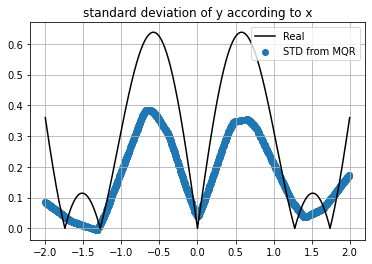

In [49]:
from scipy.stats import norm
plt.plot(x,y_std,'-k',label = 'Real') # 실제 표준편차
std_MQR = ((test_Y_HATS[...,2]-test_Y_HATS[...,1]) + (test_Y_HATS[...,3]-test_Y_HATS[...,2]))/(2*norm.ppf(0.8))
plt.scatter(test_X,std_MQR,label='STD from MQR')
plt.grid()
plt.legend()
plt.title('standard deviation of y according to x')

# Probabilistic Evaluation Metric

지금까지 GNLL, Quantile regression을 통한 확률적 예측 수행 방법을 살펴보았습니다. 다음으로 모델을 통해 얻은 확률적 예측 결과를 평가하는 지표인 Winkler score를 만들어 보도록하겠습니다.

Winkler score는 prediction interval 사이의 거리를 기준으로 실제값이 관측 범위를 벗어나면 페널티를 부과합니다.

In [50]:

#80% (1-a) = 80, a = 0.2
alpha = 0.2
#Winkler score 80%
U = test_Y_HATS[...,4]
L = test_Y_HATS[...,0]
delta = U-L
winkler_score = delta.copy()
winkler_score[test_Y<L] = (delta +2*(L-test_Y)/alpha)[test_Y<L]
winkler_score[test_Y>U] = (delta +2*(test_Y-U)/alpha)[test_Y>U]
winklers = winkler_score.mean(axis=1)


In [53]:
print("평균 Winkler score", winklers.mean())


평균 Winkler score 1.1015779
